## Imports

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import pycwt as wavelet
import scipy.constants as const
import xarray as xr
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from matplotlib.pyplot import MultipleLocator
from pycwt.helpers import find
from pyproj import Transformer as geo_transformer
from scipy.signal import butter, detrend, filtfilt, savgol_filter

In [2]:
import gc
from pathlib import Path
from pprint import pprint

import tomllib

## Baisic Functions

### Geo Coords Transformer & Distance Measurement 

In [3]:
def lla2ecef(lon, lat, alt):
    lla = {'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84'}
    ecef = {'proj': 'geocent', 'ellps': 'WGS84', 'datum': 'WGS84'}
    transformer = geo_transformer.from_crs(lla, ecef, always_xy=True)
    return transformer.transform(lon, lat, alt, radians=False)


def ecef2lla(x, y, z):
    lla = {'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84'}
    ecef = {'proj': 'geocent', 'ellps': 'WGS84', 'datum': 'WGS84'}
    transformer = geo_transformer.from_crs(ecef, lla, always_xy=True)
    return transformer.transform(x, y, z, radians=False)

def measure_dist_bear_orient(epicenter_ll, IPP_ll, radians=False):
    """units: {distance: km, bearing: radians}"""

    #     radium = 6378+400
    # Height =  400*1000
    Height = 0

    lambda_a, phi_a = epicenter_ll
    if lambda_a < 0:
        lambda_a += 360

    lambda_b, phi_b = IPP_ll
    if lambda_b < 0:
        lambda_b += 360

    x1, y1, z1 = lla2ecef(lambda_a, phi_a, Height)
    x2, y2, z2 = lla2ecef(lambda_b, phi_b, Height)

    vector1 = np.array([x1, y1, z1])
    radium1 = np.sqrt(np.dot(vector1, vector1)) / 1000

    vector2 = np.array([x2, y2, z2])
    radium2 = np.sqrt(np.dot(vector2, vector2)) / 1000

    radium = (radium1 + radium2) / 2
    #     print('radium:', radium)

    if not radians:
        lambda_a = np.radians(lambda_a)
        lambda_b = np.radians(lambda_b)
        phi_a = np.radians(phi_a)
        phi_b = np.radians(phi_b)

    cosine = np.cos(phi_a) * np.cos(phi_b) * np.cos(lambda_a - lambda_b) + np.sin(
        phi_a
    ) * np.sin(phi_b)

    delta = np.arccos(cosine)
    distance = radium * delta

    tangent = (
        np.sin(lambda_b - lambda_a)
        * np.cos(phi_b)
        * np.cos(phi_a)
        / (np.sin(phi_b) - np.sin(phi_a) * cosine)
    )
    bearing = np.arctan2(abs(tangent), 1)

    if lambda_b > lambda_a:
        if phi_b > phi_a:
            bearing = bearing
        elif phi_b < phi_a:
            bearing = np.pi - bearing
        else:
            bearing = np.pi / 2

    elif lambda_b < lambda_a:
        if phi_b > phi_a:
            bearing = 2 * np.pi - bearing
        elif phi_b < phi_a:
            bearing = np.pi + bearing
        else:
            bearing = 3 * np.pi / 2

    else:
        if phi_b >= phi_a:
            bearing = 0
        elif phi_b < phi_a:
            bearing = np.pi

    quarter = np.pi / 4

    if bearing >= 0 and bearing < quarter:
        orientation = 'N.E.'

    elif bearing >= quarter and bearing < 2 * quarter:
        orientation = 'E.N.'

    elif bearing >= 2 * quarter and bearing < 3 * quarter:
        orientation = 'E.S.'

    elif bearing >= 3 * quarter and bearing < 4 * quarter:
        orientation = 'S.E.'

    elif bearing >= 4 * quarter and bearing < 5 * quarter:
        orientation = 'S.W.'

    elif bearing >= 5 * quarter and bearing < 6 * quarter:
        orientation = 'W.S.'

    elif bearing >= 6 * quarter and bearing < 7 * quarter:
        orientation = 'W.N.'

    else:
        orientation = 'N.W.'

    return distance, bearing, orientation

### Time-axis Ticks Formatter

In [4]:
def format_func(x, pos=None):
    x = mdates.num2date(x)
    if x.hour == 0:
        fmt = '%H\n%b %d'
    else:
        fmt = '%H'
    label = x.strftime(fmt)

    return label

### New Colormaps

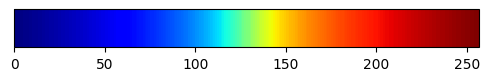

In [5]:
def show_cmap(cmap, norm=None, extend=None):
    '''展示一个colormap.'''
    if norm is None:
        norm = mcolors.Normalize(vmin=0, vmax=cmap.N)
    im = cm.ScalarMappable(norm=norm, cmap=cmap)

    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
    fig.colorbar(im, cax=ax, orientation='horizontal', extend=extend)
    plt.show()

# def new_cmap():
#     nodes = [0,0.05,  
#              0.15, 
#                 0.45, 0.495, 
#                 0.5, 
#                 0.505, 0.55, 
#                 0.85, 
#                 0.95,1]
#     colors = ['darkblue', 'mediumblue', 
#               'blue', 
#             # 'lightcyan', 'lightcyan', 
#             'paleturquoise', 'lightcyan', 
#             'honeydew', 
#              'lightyellow', 'lemonchiffon',
#             # 'yellow', 'yellow', 
#             # 'lightyellow', 'lightyellow', 
#             'crimson', 
#             'firebrick', 'darkred'
#             ]

#     new_cmap = mcolors.LinearSegmentedColormap.from_list(
#                     'cmap2', list(zip(nodes, colors)))


#     return new_cmap

# new_cmap1 = new_cmap()
def create_cmap(base = 10):
    if base == 10:
        nodes = np.hstack((
            np.log10(np.linspace(10, 1.02, 128)) * (-1), 
            0, 
            np.log10(np.linspace(1.02, 10, 128))
        ))
        
    elif base == 2:
        nodes = np.hstack((
            np.log2(np.linspace(2, 1.01, 128)) * (-1), 
            0, 
            np.log2(np.linspace(1.01, 2, 128))
        ))
    else: 
        return None

    nodes += 1
    nodes /= 2
    cmap = cm.jet
    new_cmap = mcolors.ListedColormap(cmap(nodes))
    show_cmap(new_cmap)
    return new_cmap

new_cmap = create_cmap()

## Data & Signal Processing

### Sigal Filters

In [6]:
class Signal(object):
    def __init__(self, signals, sample_rate):
        self.name = 'signals'
        # self.signals = signals
        self.sample_rate = sample_rate

        nan_idx = np.isnan(signals)
        # 找到数组中非 NaN 值的位置
        not_nan_idx = np.logical_not(nan_idx)
        # 使用插值函数 interp() 对 NaN 值进行插值
        signals[nan_idx] = np.interp(
            nan_idx.nonzero()[0], not_nan_idx.nonzero()[0], signals[not_nan_idx]
        )
        self.signals = signals

    def butter_bandpass(self, cut_off_frequency_list, order=5):
        """带通滤波器，需要两个截止频率，以 list 形式输入"""
        self.nyq = 0.5 * self.sample_rate
        normal_cut_off = np.array(cut_off_frequency_list) / self.nyq
        b, a = butter(order, normal_cut_off, btype='bandpass', analog=False)
        return b, a

    def butter_bandpass_filtfilt(self, cut_off_frequency_list, order=5):
        """带通滤波器的执行，消除延迟"""
        b, a = self.butter_bandpass(cut_off_frequency_list, order=order)
        y = filtfilt(b, a, self.signals)
        return y

    def savgol_dtrend_filter(self, winlong, winshort, order=3):
        trend = savgol_filter(self.signals, winlong, order)
        if winshort == 0:
            dtrend = self.signals - trend
            return dtrend
        else:
            dtrend = self.signals - trend
            bandpass = savgol_filter(dtrend, winshort, order)
            return bandpass

## Plots settings

### Basic Maps setting

In [7]:
def set_maps(bx, dx, fx, hx, focus_posi, proj):
    res = '10m'
    for the_ax in [bx, dx, fx, hx]:
        the_ax.add_feature(
        cfeature.LAND.with_scale(res), edgecolor='black', lw=0.12, facecolor='white'
        )
        the_ax.add_feature(cfeature.OCEAN.with_scale(res), facecolor='navy', alpha=0.06)
        the_ax.add_feature(cfeature.BORDERS.with_scale(res), edgecolor='black', lw=0.1)

        the_ax.xaxis.set_major_formatter(LongitudeFormatter())
        the_ax.yaxis.set_major_formatter(LatitudeFormatter())
        the_ax.scatter(
            focus_posi[0], focus_posi[1], c='crimson', transform=proj, s=50, marker='X'
        )
    
    minlat, maxlat = focus_posi[1]-1, focus_posi[1]+14
    minlon, maxlon = focus_posi[0]-1, focus_posi[0]+14
    extents = [minlon, maxlon, minlat, maxlat]
    bx.set_extent(extents, crs=proj)
    bx.set_xticks(np.arange(np.floor(minlon), np.ceil(maxlon), 5), crs=proj)
    bx.set_yticks(np.arange(np.floor(minlat), np.ceil(maxlat), 5), crs=proj)
    

    minlat, maxlat = focus_posi[1]-14, focus_posi[1]+1
    minlon, maxlon = focus_posi[0]-1, focus_posi[0]+14
    extents = [minlon, maxlon, minlat, maxlat]
    dx.set_extent(extents, crs=proj)
    dx.set_xticks(np.arange(np.floor(minlon), np.ceil(maxlon), 5), crs=proj)
    dx.set_yticks(np.arange(np.floor(minlat), np.ceil(maxlat), 5), crs=proj)
    
    minlat, maxlat = focus_posi[1]-14, focus_posi[1]+1
    minlon, maxlon = focus_posi[0]-14, focus_posi[0]+1
    extents = [minlon, maxlon, minlat, maxlat]
    fx.set_extent(extents, crs=proj)
    fx.set_xticks(np.arange(np.floor(minlon), np.ceil(maxlon), 5), crs=proj)
    fx.set_yticks(np.arange(np.floor(minlat), np.ceil(maxlat), 5), crs=proj)
    
    minlat, maxlat = focus_posi[1]-1, focus_posi[1]+14
    minlon, maxlon = focus_posi[0]-14, focus_posi[0]+1
    extents = [minlon, maxlon, minlat, maxlat]
    hx.set_extent(extents, crs=proj)
    hx.set_xticks(np.arange(np.floor(minlon), np.ceil(maxlon), 5), crs=proj)
    hx.set_yticks(np.arange(np.floor(minlat), np.ceil(maxlat), 5), crs=proj)
    

### Travel Time plots

In [20]:
def plot_vars(
    leftx,
    rightx,
    t_range,
    dist,
    notrend,
    site_posi,
    ipp_posi,
    new_cmap,
    vmax=0.7,
    s=5,
    proj=ccrs.PlateCarree(),
    skip=10,
    marker=',',
    alpha=1
):
    try:
        im = leftx.scatter(
            t_range[::skip],
            [dist] * t_range[::skip].size,
            c=notrend[::skip],
            cmap=new_cmap,
            vmin=-vmax,
            vmax=vmax,
            s=s,
            marker=marker,
            alpha=alpha,
        # extend='both'
        )
    except Exception as e:
        print(e)
        
    rightx.scatter(site_posi[0], site_posi[1], c='k', transform=proj, s=27, marker='^')
    rightx.scatter(ipp_posi[0], ipp_posi[1], c='deepskyblue', transform=proj, s=15, marker='o')
    return im

### Add Speed Line

In [9]:
def add_speed_line(ax, 
               arrival_t, 
               arrival_d, 
               dinterval = 1*const.kilo, 
               sunit = 'm/s', 
               scalar = 0.12,
               xytext = [10, 0],
               lw = 1.5
              ):
    arrival_t1, arrival_t2 = arrival_t[0], arrival_t[1]
    arrival_d1, arrival_d2 = arrival_d[0], arrival_d[1]
    ranges     = (arrival_d2-arrival_d1)
    seconds    = (arrival_t2-arrival_t1)/np.timedelta64(1,'s')
    speed      = ranges * dinterval/seconds
    str_speed  = f'{speed:4.0f}{sunit}'
    ax.plot([arrival_t1, arrival_t2], 
                [arrival_d1, arrival_d2], 
                color = 'k',
                lw = lw,
               )
    # scalar = 0.12
    
    tnote = arrival_t1 + np.timedelta64(int(seconds*scalar), 's')
    rnote = arrival_d1 + ranges*scalar
    ax.annotate(str_speed, 
                 [tnote, rnote],
                 xytext=xytext, 
                 textcoords='offset points',
                 fontsize = 15
                )

## Display Types

### Initiation Arguments & Settings 

In [10]:
p_toml = '/home/koi/pypoetry/earthquake_cases.toml'
event = 'Jishishan'

with open(p_toml, mode='rb') as f_toml:
    case = tomllib.load(f_toml)[event]
    pprint(case)

focus_posi, occur_UT = case['geo_posi'], case['occur_UT']
occur_UT = np.datetime64(occur_UT, 'm')

obs_net = 'CMONOC'
constellation = 'BeiDou'
H_orbit = 35786 * const.kilo
BeiDou_posi = {
    'C01': [140.0, 0, H_orbit],
    'C02': [80.07, 0, H_orbit],
    'C03': [110.45, 0, H_orbit],
    'C04': [159.98, 0, H_orbit],
    'C05': [58.71, 0, H_orbit],
}

t_interval = 1  # unit: second
f_nc = '/home/koi/pypoetry/BeiDou_TEC_352_01s_2023.nc'
nc = xr.open_dataset(f_nc)
df = pd.read_csv('/home/koi/pypoetry/GNSS_TEC/CMONOC_sites.csv')

{'depth': 10,
 'district': ['China', 'Gansu', 'Linxia', 'Jshishan'],
 'geo_posi': [102.79, 35.7],
 'magnitude': 6.2,
 'occur_UT': '2023-12-18T15:59:30'}


### Periods: 128min-96min

In [11]:
winlong, winshort = 128, 96

#### Sv: C01

In [12]:
def plot_Travel_Time_Diagram_128_96_C01(
    nc,
    df,
    focus_posi,
    occur_UT,
    BeiDou_posi,
    t_interval,
    winlong,
    winshort,
    sv='C01',
    to_save=False,
):
    # t_start = np.datetime64('2023-12-18T00:00:00')
    # t_end = np.datetime64('2023-12-19T00:00:00')
    # t_range = pd.date_range(t_start, t_end, freq=f'{t_interval}s')

    # obs_sites = ['WUHN']
    obs_sites = nc.observer.values

    t_start = np.datetime64('2023-12-18T00:00:00')
    t_end = np.datetime64('2023-12-18T18:00:00')
    # unit: minute

    p_units = 'min'
    v_units = 'km'
    label = f'DTEC'
    ylabel = 'Distance'
    title = f'{winlong}-{winshort}{p_units} Filtered {sv} {label}'
    f_path = f'/home/koi/pypoetry/GNSS_TEC/plots'
    f_save = f'{f_path}/traveltime_{sv}_{label}{winlong}-{winshort}{p_units}.png'

    fig = plt.figure(figsize=(13, 13))
    fig.suptitle(title, x=0.5, y=0.915)
    ax = plt.axes([0.10, 0.73, 0.62, 0.15])
    cx = plt.axes([0.10, 0.52, 0.62, 0.15], sharex=ax, sharey=ax)
    ex = plt.axes([0.10, 0.31, 0.62, 0.15], sharex=ax, sharey=ax)
    gx = plt.axes([0.10, 0.1, 0.62, 0.15], sharex=ax, sharey=ax)

    proj = ccrs.PlateCarree()
    bx = plt.axes([0.77, 0.73, 0.15, 0.15], projection=proj)
    dx = plt.axes([0.77, 0.52, 0.15, 0.15], projection=proj)
    fx = plt.axes([0.77, 0.31, 0.15, 0.15], projection=proj)
    hx = plt.axes([0.77, 0.1, 0.15, 0.15], projection=proj)
    cbarx = fig.add_axes([0.25, 0.03, 0.32, 0.014])
    set_maps(bx, dx, fx, hx, focus_posi, proj)

    ax.set_title(f'a) N.E. {label}', loc='left'), bx.set_title(f'b) IPPs', loc='left')
    cx.set_title(f'c) S.E. {label}', loc='left'), dx.set_title(f'd) IPPs', loc='left')
    ex.set_title(f'e) S.W. {label}', loc='left'), fx.set_title(f'f) IPPs', loc='left')
    gx.set_title(f'g) N.W. {label}', loc='left'), hx.set_title(f'h) IPPs', loc='left')

    # site = 'WUHN'
    for site in obs_sites:
        svs = nc.sel(observer=site).sv.values
        if sv not in svs:
            continue
        else:
            pass

        # if Path(f_save).is_file():
        #     continue
        # else:
        #     pass

        site_posi = [
            df[df.OBSERVATION == site].LON.values,
            df[df.OBSERVATION == site].LAT.values,
        ]
        # pprint(site_posi)
        # continue
        # site_posi = [114.3573, 30.5317]
        stec = nc.sTEC_smth.sel(observer=site, sv=sv).dropna(dim='time')
        t_range = stec.time.loc[t_start:t_end]
        stec = stec.sel(time=t_range).values

        if stec.size < int(12 * 60 * 60 / t_interval):
            continue

        # stec = stec.interp(
        #     time=t_range, method='linear', kwargs={'fill_value': 'extrapolate'}
        # )
        # t_range = stec.time
        zenith = nc.zenith.sel(observer=site, sv=sv).values
        ipp_posi = [
            nc.lon.sel(observer=site, sv=sv).values,
            nc.lat.sel(observer=site, sv=sv).values,
        ]

        maxdist = 1200  ## unit: km
        dist, bear, _ = measure_dist_bear_orient(focus_posi, ipp_posi)
        if dist > maxdist:
            continue
        else:
            pass

        vtec = stec * np.cos(zenith)
        ### normalization
        data = Signal(vtec, t_interval)

        notrend = data.savgol_dtrend_filter(winlong * 60 + 1, winshort * 60 + 1)

        one_quarter = np.pi / 2
        if bear >= 0 and bear < one_quarter:
            leftx, rightx = ax, bx
        elif bear >= one_quarter and bear < 2 * one_quarter:
            leftx, rightx = cx, dx
        elif bear >= 2 * one_quarter and bear < 3 * one_quarter:
            leftx, rightx = ex, fx
        else:
            leftx, rightx = gx, hx
        im = plot_vars(
            leftx, rightx, t_range, dist, notrend, site_posi, ipp_posi, new_cmap, vmax=1
        )

    fig.colorbar(im, cax=cbarx, orientation='horizontal', extend='both', pad=0.02)

    arrival_t = (
        np.datetime64('2023-12-18T01:35:00'),
        np.datetime64('2023-12-18T02:38:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        ax,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.2,
        xytext=[3, 0],
        lw=3,
    )

    arrival_t = (
        np.datetime64('2023-12-18T00:25:00'),
        np.datetime64('2023-12-18T00:56:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.14,
        xytext=[2, 0],
    )

    arrival_t = (
        np.datetime64('2023-12-18T01:35:00'),
        np.datetime64('2023-12-18T02:50:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.01,
        xytext=[3, 0],
        lw=3,
    )

    arrival_t = (
        np.datetime64('2023-12-18T06:00:00'),
        np.datetime64('2023-12-18T08:10:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.01,
        xytext=[3, 0],
    )

    arrival_t = (
        np.datetime64('2023-12-18T01:35:00'),
        np.datetime64('2023-12-18T02:25:00'),
    )
    arrival_d = 600, 1200
    add_speed_line(
        ex,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.2,
        xytext=[1, -5],
        lw=3,
    )

    for the_ax in [ax, cx, ex, gx]:
        the_ax.axvline(occur_UT, color='#cccccc', alpha=0.9, ls='--', lw=2)
        the_ax.set_ylabel(f'{ylabel} ({v_units})')

    ax.set_xlim([t_start, t_end])
    ax.set_ylim([0, maxdist])
    ticks = np.arange(0, 26, 2)
    ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(format_func)

    gx.set_xlabel(f'Time (UT)')
    if to_save:
        fig.savefig(f_save, bbox_inches='tight')
    else:
        plt.show()
    plt.clf()
    plt.close('all')
    gc.collect()


# plot_Travel_Time_Diagram_128_96_C01(
#     nc, df, focus_posi, occur_UT, BeiDou_posi, t_interval, winlong, winshort, sv,
#     to_save = True
# )

#### Sv: C02

In [13]:
def plot_Travel_Time_Diagram_128_96_C02(
    nc,
    df,
    focus_posi,
    occur_UT,
    BeiDou_posi,
    t_interval,
    winlong,
    winshort,
    sv='C02',
    to_save=False,
):
    # t_start = np.datetime64('2023-12-18T00:00:00')
    # t_end = np.datetime64('2023-12-19T00:00:00')
    # t_range = pd.date_range(t_start, t_end, freq=f'{t_interval}s')

    # obs_sites = ['WUHN']
    obs_sites = nc.observer.values

    t_start = np.datetime64('2023-12-18T00:00:00')
    t_end = np.datetime64('2023-12-18T18:00:00')
    # unit: minute

    p_units = 'min'
    v_units = 'km'
    label = f'DTEC'
    ylabel = 'Distance'
    title = f'{winlong}-{winshort}{p_units} Filtered {sv} {label}'
    f_path = f'/home/koi/pypoetry/GNSS_TEC/plots'
    f_save = f'{f_path}/traveltime_{sv}_{label}{winlong}-{winshort}{p_units}.png'

    fig = plt.figure(figsize=(13, 13))
    fig.suptitle(title, x=0.5, y=0.915)
    ax = plt.axes([0.10, 0.73, 0.62, 0.15])
    cx = plt.axes([0.10, 0.52, 0.62, 0.15], sharex=ax, sharey=ax)
    ex = plt.axes([0.10, 0.31, 0.62, 0.15], sharex=ax, sharey=ax)
    gx = plt.axes([0.10, 0.1, 0.62, 0.15], sharex=ax, sharey=ax)

    proj = ccrs.PlateCarree()
    bx = plt.axes([0.77, 0.73, 0.15, 0.15], projection=proj)
    dx = plt.axes([0.77, 0.52, 0.15, 0.15], projection=proj)
    fx = plt.axes([0.77, 0.31, 0.15, 0.15], projection=proj)
    hx = plt.axes([0.77, 0.1, 0.15, 0.15], projection=proj)
    cbarx = fig.add_axes([0.25, 0.03, 0.32, 0.014])
    set_maps(bx, dx, fx, hx, focus_posi, proj)

    ax.set_title(f'a) N.E. {label}', loc='left'), bx.set_title(f'b) IPPs', loc='left')
    cx.set_title(f'c) S.E. {label}', loc='left'), dx.set_title(f'd) IPPs', loc='left')
    ex.set_title(f'e) S.W. {label}', loc='left'), fx.set_title(f'f) IPPs', loc='left')
    gx.set_title(f'g) N.W. {label}', loc='left'), hx.set_title(f'h) IPPs', loc='left')

    # site = 'WUHN'
    for site in obs_sites:
        svs = nc.sel(observer=site).sv.values
        if sv not in svs:
            continue
        else:
            pass

        # if Path(f_save).is_file():
        #     continue
        # else:
        #     pass

        site_posi = [
            df[df.OBSERVATION == site].LON.values,
            df[df.OBSERVATION == site].LAT.values,
        ]
        # pprint(site_posi)
        # continue
        # site_posi = [114.3573, 30.5317]
        stec = nc.sTEC_smth.sel(observer=site, sv=sv).dropna(dim='time')
        t_range = stec.time.loc[t_start:t_end]
        stec = stec.sel(time=t_range).values

        if stec.size < int(12 * 60 * 60 / t_interval):
            continue

        # stec = stec.interp(
        #     time=t_range, method='linear', kwargs={'fill_value': 'extrapolate'}
        # )
        # t_range = stec.time
        zenith = nc.zenith.sel(observer=site, sv=sv).values
        ipp_posi = [
            nc.lon.sel(observer=site, sv=sv).values,
            nc.lat.sel(observer=site, sv=sv).values,
        ]

        maxdist = 1200  ## unit: km
        dist, bear, _ = measure_dist_bear_orient(focus_posi, ipp_posi)
        if dist > maxdist:
            continue
        else:
            pass

        vtec = stec * np.cos(zenith)
        ### normalization
        data = Signal(vtec, t_interval)

        notrend = data.savgol_dtrend_filter(winlong * 60 + 1, winshort * 60 + 1)

        one_quarter = np.pi / 2
        if bear >= 0 and bear < one_quarter:
            leftx, rightx = ax, bx
        elif bear >= one_quarter and bear < 2 * one_quarter:
            leftx, rightx = cx, dx
        elif bear >= 2 * one_quarter and bear < 3 * one_quarter:
            leftx, rightx = ex, fx
        else:
            leftx, rightx = gx, hx

        im = plot_vars(
            leftx,
            rightx,
            t_range,
            dist,
            notrend,
            site_posi,
            ipp_posi,
            new_cmap,
            vmax=1,
            s=3,
        )

    fig.colorbar(im, cax=cbarx, orientation='horizontal', extend='both', pad=0.02)

    arrival_t = (
        np.datetime64('2023-12-18T01:35:00'),
        np.datetime64('2023-12-18T02:38:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        ax,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.2,
        xytext=[3, -6],
        lw=3,
    )

    arrival_t = (
        np.datetime64('2023-12-18T01:35:00'),
        np.datetime64('2023-12-18T02:50:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.01,
        xytext=[3, 1],
        lw=3,
    )

    arrival_t = (
        np.datetime64('2023-12-18T02:00:00'),
        np.datetime64('2023-12-18T02:35:00'),
    )
    arrival_d = 800, 1200
    add_speed_line(
        ex,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.02,
        xytext=[1, -6],
        lw=3,
    )

    arrival_t = (
        np.datetime64('2023-12-18T09:30:00'),
        np.datetime64('2023-12-18T10:00:00'),
    )
    arrival_d = 0, 700
    add_speed_line(
        ex,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.02,
        xytext=[-65, 0],
    )

    arrival_t = (
        np.datetime64('2023-12-18T11:00:00'),
        np.datetime64('2023-12-18T11:33:00'),
    )
    arrival_d = 0, 700
    add_speed_line(
        ex,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.02,
        xytext=[1, 0],
    )

    for the_ax in [ax, cx, ex, gx]:
        the_ax.axvline(occur_UT, color='#cccccc', alpha=0.9, ls='--', lw=2)
        the_ax.set_ylabel(f'{ylabel} ({v_units})')

    ax.set_xlim([t_start, t_end])
    ax.set_ylim([0, maxdist])
    ticks = np.arange(0, 26, 2)
    ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(format_func)

    gx.set_xlabel(f'Time (UT)')
    if to_save:
        fig.savefig(f_save, bbox_inches='tight')
    else:
        plt.show()
    plt.clf()
    plt.close('all')
    gc.collect()


# plot_Travel_Time_Diagram_128_96_C02(
#     nc, df, focus_posi, occur_UT, BeiDou_posi, t_interval, winlong, winshort, sv,
#     to_save = True
# )

#### Sv: C03

In [14]:
def plot_Travel_Time_Diagram_128_96_C03(
    nc,
    df,
    focus_posi,
    occur_UT,
    BeiDou_posi,
    t_interval,
    winlong,
    winshort,
    sv='C03',
    to_save=False,
):
    # t_start = np.datetime64('2023-12-18T00:00:00')
    # t_end = np.datetime64('2023-12-19T00:00:00')
    # t_range = pd.date_range(t_start, t_end, freq=f'{t_interval}s')

    # obs_sites = ['WUHN']
    obs_sites = nc.observer.values

    t_start = np.datetime64('2023-12-18T00:00:00')
    t_end = np.datetime64('2023-12-18T18:00:00')
    # unit: minute

    p_units = 'min'
    v_units = 'km'
    label = f'DTEC'
    ylabel = 'Distance'
    title = f'{winlong}-{winshort}{p_units} Filtered {sv} {label}'
    f_path = f'/home/koi/pypoetry/GNSS_TEC/plots'
    f_save = f'{f_path}/traveltime_{sv}_{label}{winlong}-{winshort}{p_units}.png'

    fig = plt.figure(figsize=(13, 13))
    fig.suptitle(title, x=0.5, y=0.915)
    ax = plt.axes([0.10, 0.73, 0.62, 0.15])
    cx = plt.axes([0.10, 0.52, 0.62, 0.15], sharex=ax, sharey=ax)
    ex = plt.axes([0.10, 0.31, 0.62, 0.15], sharex=ax, sharey=ax)
    gx = plt.axes([0.10, 0.1, 0.62, 0.15], sharex=ax, sharey=ax)

    proj = ccrs.PlateCarree()
    bx = plt.axes([0.77, 0.73, 0.15, 0.15], projection=proj)
    dx = plt.axes([0.77, 0.52, 0.15, 0.15], projection=proj)
    fx = plt.axes([0.77, 0.31, 0.15, 0.15], projection=proj)
    hx = plt.axes([0.77, 0.1, 0.15, 0.15], projection=proj)
    cbarx = fig.add_axes([0.25, 0.03, 0.32, 0.014])
    set_maps(bx, dx, fx, hx, focus_posi, proj)

    ax.set_title(f'a) N.E. {label}', loc='left'), bx.set_title(f'b) IPPs', loc='left')
    cx.set_title(f'c) S.E. {label}', loc='left'), dx.set_title(f'd) IPPs', loc='left')
    ex.set_title(f'e) S.W. {label}', loc='left'), fx.set_title(f'f) IPPs', loc='left')
    gx.set_title(f'g) N.W. {label}', loc='left'), hx.set_title(f'h) IPPs', loc='left')

    # site = 'WUHN'
    for site in obs_sites:
        svs = nc.sel(observer=site).sv.values
        if sv not in svs:
            continue
        else:
            pass

        # if Path(f_save).is_file():
        #     continue
        # else:
        #     pass

        site_posi = [
            df[df.OBSERVATION == site].LON.values,
            df[df.OBSERVATION == site].LAT.values,
        ]
        # pprint(site_posi)
        # continue
        # site_posi = [114.3573, 30.5317]
        stec = nc.sTEC_smth.sel(observer=site, sv=sv).dropna(dim='time')
        t_range = stec.time.loc[t_start:t_end]
        stec = stec.sel(time=t_range).values

        if stec.size < int(12 * 60 * 60 / t_interval):
            continue

        # stec = stec.interp(
        #     time=t_range, method='linear', kwargs={'fill_value': 'extrapolate'}
        # )
        # t_range = stec.time
        zenith = nc.zenith.sel(observer=site, sv=sv).values
        ipp_posi = [
            nc.lon.sel(observer=site, sv=sv).values,
            nc.lat.sel(observer=site, sv=sv).values,
        ]

        maxdist = 1200  ## unit: km
        dist, bear, _ = measure_dist_bear_orient(focus_posi, ipp_posi)
        if dist > maxdist:
            continue
        else:
            pass

        vtec = stec * np.cos(zenith)
        ### normalization
        data = Signal(vtec, t_interval)

        notrend = data.savgol_dtrend_filter(winlong * 60 + 1, winshort * 60 + 1)

        one_quarter = np.pi / 2
        if bear >= 0 and bear < one_quarter:
            leftx, rightx = ax, bx
        elif bear >= one_quarter and bear < 2 * one_quarter:
            leftx, rightx = cx, dx
        elif bear >= 2 * one_quarter and bear < 3 * one_quarter:
            leftx, rightx = ex, fx
        else:
            leftx, rightx = gx, hx

        im = plot_vars(
            leftx,
            rightx,
            t_range,
            dist,
            notrend,
            site_posi,
            ipp_posi,
            new_cmap,
            vmax=1,
            s=3,
        )

    fig.colorbar(im, cax=cbarx, orientation='horizontal', extend='both', pad=0.02)

    arrival_t = (
        np.datetime64('2023-12-18T01:35:00'),
        np.datetime64('2023-12-18T02:38:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        ax,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.2,
        xytext=[3, -6],
        lw=3,
    )

    arrival_t = (
        np.datetime64('2023-12-18T01:35:00'),
        np.datetime64('2023-12-18T02:50:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.01,
        xytext=[0, 1],
        lw=3,
    )

    arrival_t = (
        np.datetime64('2023-12-18T03:10:00'),
        np.datetime64('2023-12-18T04:40:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.01,
        xytext=[6, 1],
    )

    arrival_t = (
        np.datetime64('2023-12-18T02:00:00'),
        np.datetime64('2023-12-18T02:35:00'),
    )
    arrival_d = 800, 1200
    add_speed_line(
        ex,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.02,
        xytext=[1, -6],
        lw=3,
    )

    arrival_t = (
        np.datetime64('2023-12-18T03:00:00'),
        np.datetime64('2023-12-18T04:40:00'),
    )
    arrival_d = 0, 700
    add_speed_line(
        ex,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.02,
        xytext=[-65, 0],
    )

    arrival_t = (
        np.datetime64('2023-12-18T09:30:00'),
        np.datetime64('2023-12-18T10:00:00'),
    )
    arrival_d = 0, 700
    add_speed_line(
        ex,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.02,
        xytext=[-65, 0],
    )

    arrival_t = (
        np.datetime64('2023-12-18T11:00:00'),
        np.datetime64('2023-12-18T11:33:00'),
    )
    arrival_d = 0, 700
    add_speed_line(
        ex,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.02,
        xytext=[1, 0],
    )

    arrival_t = (
        np.datetime64('2023-12-18T02:08:00'),
        np.datetime64('2023-12-18T04:07:00'),
    )
    arrival_d = 0, 700
    add_speed_line(
        gx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.02,
        xytext=[1, 0],
    )

    for the_ax in [ax, cx, ex, gx]:
        the_ax.axvline(occur_UT, color='#cccccc', alpha=0.9, ls='--', lw=2)
        the_ax.set_ylabel(f'{ylabel} ({v_units})')

    ax.set_xlim([t_start, t_end])
    ax.set_ylim([0, maxdist])
    ticks = np.arange(0, 26, 2)
    ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(format_func)

    gx.set_xlabel(f'Time (UT)')
    if to_save:
        fig.savefig(f_save, bbox_inches='tight')
    else:
        plt.show()
    plt.clf()
    plt.close('all')
    gc.collect()


# plot_Travel_Time_Diagram_128_96_C03(
#     nc, df, focus_posi, occur_UT, BeiDou_posi, t_interval, winlong, winshort, sv,
#     to_save = True
# )

### Periods: 96min-64min

In [15]:
winlong, winshort = 96, 64

#### Sv: C01

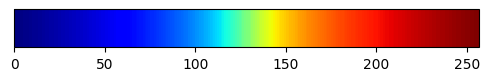

In [16]:
new_cmap = create_cmap()
def plot_Travel_Time_Diagram_96_64_C01(
    nc,
    df,
    focus_posi,
    occur_UT,
    BeiDou_posi,
    t_interval,
    winlong,
    winshort,
    sv='C01',
    to_save=False,
):
    # t_start = np.datetime64('2023-12-18T00:00:00')
    # t_end = np.datetime64('2023-12-19T00:00:00')
    # t_range = pd.date_range(t_start, t_end, freq=f'{t_interval}s')

    # obs_sites = ['WUHN']
    obs_sites = nc.observer.values

    t_start = np.datetime64('2023-12-18T00:00:00')
    t_end = np.datetime64('2023-12-18T18:00:00')
    # unit: minute

    p_units = 'min'
    v_units = 'km'
    label = f'DTEC'
    ylabel = 'Distance'
    title = f'{winlong}-{winshort}{p_units} Filtered {sv} {label}'
    f_path = f'/home/koi/pypoetry/GNSS_TEC/plots'
    f_save = f'{f_path}/traveltime_{sv}_{label}_{winlong}-{winshort}{p_units}.png'

    fig = plt.figure(figsize=(13, 13))
    fig.suptitle(title, x=0.5, y=0.915)
    ax = plt.axes([0.10, 0.73, 0.62, 0.15])
    cx = plt.axes([0.10, 0.52, 0.62, 0.15], sharex=ax, sharey=ax)
    ex = plt.axes([0.10, 0.31, 0.62, 0.15], sharex=ax, sharey=ax)
    gx = plt.axes([0.10, 0.1, 0.62, 0.15], sharex=ax, sharey=ax)

    proj = ccrs.PlateCarree()
    bx = plt.axes([0.77, 0.73, 0.15, 0.15], projection=proj)
    dx = plt.axes([0.77, 0.52, 0.15, 0.15], projection=proj)
    fx = plt.axes([0.77, 0.31, 0.15, 0.15], projection=proj)
    hx = plt.axes([0.77, 0.1, 0.15, 0.15], projection=proj)
    cbarx = fig.add_axes([0.25, 0.03, 0.32, 0.014])
    set_maps(bx, dx, fx, hx, focus_posi, proj)

    ax.set_title(f'a) N.E. {label}', loc='left'), bx.set_title(f'b) IPPs', loc='left')
    cx.set_title(f'c) S.E. {label}', loc='left'), dx.set_title(f'd) IPPs', loc='left')
    ex.set_title(f'e) S.W. {label}', loc='left'), fx.set_title(f'f) IPPs', loc='left')
    gx.set_title(f'g) N.W. {label}', loc='left'), hx.set_title(f'h) IPPs', loc='left')

    # site = 'WUHN'
    for site in obs_sites:
        svs = nc.sel(observer=site).sv.values
        if sv not in svs:
            continue
        else:
            pass

        # if Path(f_save).is_file():
        #     continue
        # else:
        #     pass

        site_posi = [
            df[df.OBSERVATION == site].LON.values,
            df[df.OBSERVATION == site].LAT.values,
        ]
        # pprint(site_posi)
        # continue
        # site_posi = [114.3573, 30.5317]
        stec = nc.sTEC_smth.sel(observer=site, sv=sv).dropna(dim='time')
        t_range = stec.time.loc[t_start:t_end]
        stec = stec.sel(time=t_range).values

        if stec.size < int(12 * 60 * 60 / t_interval):
            continue

        # stec = stec.interp(
        #     time=t_range, method='linear', kwargs={'fill_value': 'extrapolate'}
        # )
        # t_range = stec.time
        zenith = nc.zenith.sel(observer=site, sv=sv).values
        ipp_posi = [
            nc.lon.sel(observer=site, sv=sv).values,
            nc.lat.sel(observer=site, sv=sv).values,
        ]

        maxdist = 1200  ## unit: km
        dist, bear, _ = measure_dist_bear_orient(focus_posi, ipp_posi)
        if dist > maxdist:
            continue
        else:
            pass

        vtec = stec * np.cos(zenith)
        ### normalization
        data = Signal(vtec, t_interval)

        notrend = data.savgol_dtrend_filter(winlong * 60 + 1, winshort * 60 + 1)

        one_quarter = np.pi / 2
        if bear >= 0 and bear < one_quarter:
            leftx, rightx = ax, bx
        elif bear >= one_quarter and bear < 2 * one_quarter:
            leftx, rightx = cx, dx
        elif bear >= 2 * one_quarter and bear < 3 * one_quarter:
            leftx, rightx = ex, fx
        else:
            leftx, rightx = gx, hx
        
        im = plot_vars(
            leftx,
            rightx,
            t_range,
            dist,
            notrend,
            site_posi,
            ipp_posi,
            new_cmap,
            vmax=0.9,
        )

    fig.colorbar(im, cax=cbarx, orientation='horizontal', extend='both', pad=0.02)

    arrival_t = (
        np.datetime64('2023-12-18T01:35:00'),
        np.datetime64('2023-12-18T02:38:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        ax,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.2,
        xytext=[3, 0],
        lw=3,
    )

    arrival_t = (
        np.datetime64('2023-12-18T01:35:00'),
        np.datetime64('2023-12-18T02:50:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.01,
        xytext=[-65, 0],
        lw=3,
    )

    arrival_t = (
        np.datetime64('2023-12-18T03:00:00'),
        np.datetime64('2023-12-18T04:15:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=1,
        xytext=[2, 1],
    )
    
    arrival_t = (
        np.datetime64('2023-12-18T04:40:00'),
        np.datetime64('2023-12-18T06:18:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=1,
        xytext=[2, 1],
    )

    arrival_t = (
        np.datetime64('2023-12-18T01:35:00'),
        np.datetime64('2023-12-18T02:25:00'),
    )
    arrival_d = 600, 1200
    add_speed_line(
        ex,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.2,
        xytext=[1, -5],
        lw=3,
    )
    
    arrival_t = (
        np.datetime64('2023-12-18T01:10:00'),
        np.datetime64('2023-12-18T02:15:00'),
    )
    arrival_d = 520, 0
    add_speed_line(
        gx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0,
        xytext=[1, 5],
    )

    for the_ax in [ax, cx, ex, gx]:
        the_ax.axvline(occur_UT, color='#cccccc', alpha=0.9, ls='--', lw=2)
        the_ax.set_ylabel(f'{ylabel} ({v_units})')

    ax.set_xlim([t_start, t_end])
    ax.set_ylim([0, maxdist])
    ticks = np.arange(0, 26, 2)
    ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(format_func)

    gx.set_xlabel(f'Time (UT)')
    if to_save:
        fig.savefig(f_save, bbox_inches='tight')
    else:
        plt.show()
    plt.clf()
    plt.close('all')
    gc.collect()


# plot_Travel_Time_Diagram_96_64_C01(
#     nc,
#     df,
#     focus_posi,
#     occur_UT,
#     BeiDou_posi,
#     t_interval,
#     winlong,
#     winshort,
#     sv='C01',
#     to_save=True,
# )

#### Sv: C02

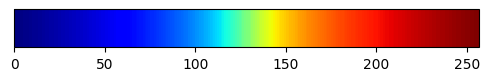

In [17]:
new_cmap = create_cmap()
def plot_Travel_Time_Diagram_96_64_C02(
    nc,
    df,
    focus_posi,
    occur_UT,
    BeiDou_posi,
    t_interval,
    winlong,
    winshort,
    sv='C02',
    to_save=False,
):
    # t_start = np.datetime64('2023-12-18T00:00:00')
    # t_end = np.datetime64('2023-12-19T00:00:00')
    # t_range = pd.date_range(t_start, t_end, freq=f'{t_interval}s')

    # obs_sites = ['WUHN']
    obs_sites = nc.observer.values

    t_start = np.datetime64('2023-12-18T00:00:00')
    t_end = np.datetime64('2023-12-18T18:00:00')
    # unit: minute

    p_units = 'min'
    v_units = 'km'
    label = f'DTEC'
    ylabel = 'Distance'
    title = f'{winlong}-{winshort}{p_units} Filtered {sv} {label}'
    f_path = f'/home/koi/pypoetry/GNSS_TEC/plots'
    f_save = f'{f_path}/traveltime_{sv}_{label}_{winlong}-{winshort}{p_units}.png'

    fig = plt.figure(figsize=(13, 13))
    fig.suptitle(title, x=0.5, y=0.915)
    ax = plt.axes([0.10, 0.73, 0.62, 0.15])
    cx = plt.axes([0.10, 0.52, 0.62, 0.15], sharex=ax, sharey=ax)
    ex = plt.axes([0.10, 0.31, 0.62, 0.15], sharex=ax, sharey=ax)
    gx = plt.axes([0.10, 0.1, 0.62, 0.15], sharex=ax, sharey=ax)

    proj = ccrs.PlateCarree()
    bx = plt.axes([0.77, 0.73, 0.15, 0.15], projection=proj)
    dx = plt.axes([0.77, 0.52, 0.15, 0.15], projection=proj)
    fx = plt.axes([0.77, 0.31, 0.15, 0.15], projection=proj)
    hx = plt.axes([0.77, 0.1, 0.15, 0.15], projection=proj)
    cbarx = fig.add_axes([0.25, 0.03, 0.32, 0.014])
    set_maps(bx, dx, fx, hx, focus_posi, proj)

    ax.set_title(f'a) N.E. {label}', loc='left'), bx.set_title(f'b) IPPs', loc='left')
    cx.set_title(f'c) S.E. {label}', loc='left'), dx.set_title(f'd) IPPs', loc='left')
    ex.set_title(f'e) S.W. {label}', loc='left'), fx.set_title(f'f) IPPs', loc='left')
    gx.set_title(f'g) N.W. {label}', loc='left'), hx.set_title(f'h) IPPs', loc='left')

    # site = 'WUHN'
    for site in obs_sites:
        svs = nc.sel(observer=site).sv.values
        if sv not in svs:
            continue
        else:
            pass

        # if Path(f_save).is_file():
        #     continue
        # else:
        #     pass

        site_posi = [
            df[df.OBSERVATION == site].LON.values,
            df[df.OBSERVATION == site].LAT.values,
        ]
        # pprint(site_posi)
        # continue
        # site_posi = [114.3573, 30.5317]
        stec = nc.sTEC_smth.sel(observer=site, sv=sv).dropna(dim='time')
        t_range = stec.time.loc[t_start:t_end]
        stec = stec.sel(time=t_range).values

        if stec.size < int(12 * 60 * 60 / t_interval):
            continue

        # stec = stec.interp(
        #     time=t_range, method='linear', kwargs={'fill_value': 'extrapolate'}
        # )
        # t_range = stec.time
        zenith = nc.zenith.sel(observer=site, sv=sv).values
        ipp_posi = [
            nc.lon.sel(observer=site, sv=sv).values,
            nc.lat.sel(observer=site, sv=sv).values,
        ]

        maxdist = 1200  ## unit: km
        dist, bear, _ = measure_dist_bear_orient(focus_posi, ipp_posi)
        if dist > maxdist:
            continue
        else:
            pass

        vtec = stec * np.cos(zenith)
        ### normalization
        data = Signal(vtec, t_interval)

        notrend = data.savgol_dtrend_filter(winlong * 60 + 1, winshort * 60 + 1)

        one_quarter = np.pi / 2
        if bear >= 0 and bear < one_quarter:
            leftx, rightx = ax, bx
        elif bear >= one_quarter and bear < 2 * one_quarter:
            leftx, rightx = cx, dx
        elif bear >= 2 * one_quarter and bear < 3 * one_quarter:
            leftx, rightx = ex, fx
        else:
            leftx, rightx = gx, hx
        
        im = plot_vars(
            leftx,
            rightx,
            t_range,
            dist,
            notrend,
            site_posi,
            ipp_posi,
            new_cmap,
            vmax=0.75,
        )

    fig.colorbar(im, cax=cbarx, orientation='horizontal', extend='both', pad=0.02)

    arrival_t = (
        np.datetime64('2023-12-18T01:35:00'),
        np.datetime64('2023-12-18T02:38:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        ax,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.15,
        xytext=[3, 0],
        lw=3,
    )

    arrival_t = (
        np.datetime64('2023-12-18T01:35:00'),
        np.datetime64('2023-12-18T02:50:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.16,
        xytext=[-65, 0],
        lw=3,
    )

    arrival_t = (
        np.datetime64('2023-12-18T03:30:00'),
        np.datetime64('2023-12-18T04:15:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.16,
        xytext=[2, 0],
    )
    
    arrival_t = (
        np.datetime64('2023-12-18T09:55:00'),
        np.datetime64('2023-12-18T10:03:00'),
    )
    arrival_d = 1200, 0
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.84,
        xytext=[2, 0],
    )
    

    arrival_t = (
        np.datetime64('2023-12-18T01:40:00'),
        np.datetime64('2023-12-18T02:30:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        ex,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.1,
        xytext=[1, -5],
    )
    
    arrival_t = (
        np.datetime64('2023-12-18T08:00:00'),
        np.datetime64('2023-12-18T08:08:00'),
    )
    arrival_d = 1200, 0
    add_speed_line(
        ex,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0,
        xytext=[1, 5],
    )
    
    arrival_t = (
        np.datetime64('2023-12-18T09:48:00'),
        np.datetime64('2023-12-18T10:08:00'),
    )
    arrival_d = 0, 750
    add_speed_line(
        ex,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.16,
        xytext=[1, -5],
    )
    
    arrival_t = (
        np.datetime64('2023-12-18T03:00:00'),
        np.datetime64('2023-12-18T04:00:00'),
    )
    arrival_d = 1000, 600
    add_speed_line(
        gx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=1,
        xytext=[1, -18],
    )

    for the_ax in [ax, cx, ex, gx]:
        the_ax.axvline(occur_UT, color='#cccccc', alpha=0.9, ls='--', lw=2)
        the_ax.set_ylabel(f'{ylabel} ({v_units})')

    ax.set_xlim([t_start, t_end])
    ax.set_ylim([0, maxdist])
    ticks = np.arange(0, 26, 2)
    ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(format_func)

    gx.set_xlabel(f'Time (UT)')
    if to_save:
        fig.savefig(f_save, bbox_inches='tight')
    else:
        plt.show()
    plt.clf()
    plt.close('all')
    gc.collect()


# plot_Travel_Time_Diagram_96_64_C02(
#     nc,
#     df,
#     focus_posi,
#     occur_UT,
#     BeiDou_posi,
#     t_interval,
#     winlong,
#     winshort,
#     sv='C02',
#     to_save=True,
# )

#### Sv: C03

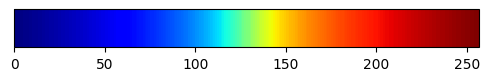

In [18]:
new_cmap = create_cmap()
def plot_Travel_Time_Diagram_96_64_C03(
    nc,
    df,
    focus_posi,
    occur_UT,
    BeiDou_posi,
    t_interval,
    winlong,
    winshort,
    sv='C03',
    to_save=False,
):
    # t_start = np.datetime64('2023-12-18T00:00:00')
    # t_end = np.datetime64('2023-12-19T00:00:00')
    # t_range = pd.date_range(t_start, t_end, freq=f'{t_interval}s')

    # obs_sites = ['WUHN']
    obs_sites = nc.observer.values

    t_start = np.datetime64('2023-12-18T00:00:00')
    t_end = np.datetime64('2023-12-18T18:00:00')
    # unit: minute

    p_units = 'min'
    v_units = 'km'
    label = f'DTEC'
    ylabel = 'Distance'
    title = f'{winlong}-{winshort}{p_units} Filtered {sv} {label}'
    f_path = f'/home/koi/pypoetry/GNSS_TEC/plots'
    f_save = f'{f_path}/traveltime_{sv}_{label}_{winlong}-{winshort}{p_units}.png'

    fig = plt.figure(figsize=(13, 13))
    fig.suptitle(title, x=0.5, y=0.915)
    ax = plt.axes([0.10, 0.73, 0.62, 0.15])
    cx = plt.axes([0.10, 0.52, 0.62, 0.15], sharex=ax, sharey=ax)
    ex = plt.axes([0.10, 0.31, 0.62, 0.15], sharex=ax, sharey=ax)
    gx = plt.axes([0.10, 0.1, 0.62, 0.15], sharex=ax, sharey=ax)

    proj = ccrs.PlateCarree()
    bx = plt.axes([0.77, 0.73, 0.15, 0.15], projection=proj)
    dx = plt.axes([0.77, 0.52, 0.15, 0.15], projection=proj)
    fx = plt.axes([0.77, 0.31, 0.15, 0.15], projection=proj)
    hx = plt.axes([0.77, 0.1, 0.15, 0.15], projection=proj)
    cbarx = fig.add_axes([0.25, 0.03, 0.32, 0.014])
    set_maps(bx, dx, fx, hx, focus_posi, proj)

    ax.set_title(f'a) N.E. {label}', loc='left'), bx.set_title(f'b) IPPs', loc='left')
    cx.set_title(f'c) S.E. {label}', loc='left'), dx.set_title(f'd) IPPs', loc='left')
    ex.set_title(f'e) S.W. {label}', loc='left'), fx.set_title(f'f) IPPs', loc='left')
    gx.set_title(f'g) N.W. {label}', loc='left'), hx.set_title(f'h) IPPs', loc='left')

    # site = 'WUHN'
    for site in obs_sites:
        svs = nc.sel(observer=site).sv.values
        if sv not in svs:
            continue
        else:
            pass

        # if Path(f_save).is_file():
        #     continue
        # else:
        #     pass

        site_posi = [
            df[df.OBSERVATION == site].LON.values,
            df[df.OBSERVATION == site].LAT.values,
        ]
        # pprint(site_posi)
        # continue
        # site_posi = [114.3573, 30.5317]
        stec = nc.sTEC_smth.sel(observer=site, sv=sv).dropna(dim='time')
        t_range = stec.time.loc[t_start:t_end]
        stec = stec.sel(time=t_range).values

        if stec.size < int(12 * 60 * 60 / t_interval):
            continue

        # stec = stec.interp(
        #     time=t_range, method='linear', kwargs={'fill_value': 'extrapolate'}
        # )
        # t_range = stec.time
        zenith = nc.zenith.sel(observer=site, sv=sv).values
        ipp_posi = [
            nc.lon.sel(observer=site, sv=sv).values,
            nc.lat.sel(observer=site, sv=sv).values,
        ]

        maxdist = 1200  ## unit: km
        dist, bear, _ = measure_dist_bear_orient(focus_posi, ipp_posi)
        if dist > maxdist:
            continue
        else:
            pass

        vtec = stec * np.cos(zenith)
        ### normalization
        data = Signal(vtec, t_interval)

        notrend = data.savgol_dtrend_filter(winlong * 60 + 1, winshort * 60 + 1)

        one_quarter = np.pi / 2
        if bear >= 0 and bear < one_quarter:
            leftx, rightx = ax, bx
        elif bear >= one_quarter and bear < 2 * one_quarter:
            leftx, rightx = cx, dx
        elif bear >= 2 * one_quarter and bear < 3 * one_quarter:
            leftx, rightx = ex, fx
        else:
            leftx, rightx = gx, hx
        
        im = plot_vars(
            leftx,
            rightx,
            t_range,
            dist,
            notrend,
            site_posi,
            ipp_posi,
            new_cmap,
            vmax=0.75,
        )

    fig.colorbar(im, cax=cbarx, orientation='horizontal', extend='both', pad=0.02)

    arrival_t = (
        np.datetime64('2023-12-18T01:35:00'),
        np.datetime64('2023-12-18T02:38:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        ax,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.15,
        xytext=[3, 0],
        lw=3,
    )

    arrival_t = (
        np.datetime64('2023-12-18T01:35:00'),
        np.datetime64('2023-12-18T02:50:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=1,
        xytext=[1, 5],
        lw=3,
    )

    arrival_t = (
        np.datetime64('2023-12-18T04:40:00'),
        np.datetime64('2023-12-18T06:40:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=1,
        xytext=[1, 5],
    )
    
    arrival_t = (
        np.datetime64('2023-12-18T09:55:00'),
        np.datetime64('2023-12-18T10:03:00'),
    )
    arrival_d = 1200, 0
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0,
        xytext=[1, 5],
    )
    
    arrival_t = (
        np.datetime64('2023-12-18T08:00:00'),
        np.datetime64('2023-12-18T08:05:20'),
    )
    arrival_d = 1200, 400
    add_speed_line(
        ex,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0,
        xytext=[1, 5],
    )
    
    arrival_t = (
        np.datetime64('2023-12-18T09:48:00'),
        np.datetime64('2023-12-18T10:08:00'),
    )
    arrival_d = 0, 750
    add_speed_line(
        ex,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.01,
        xytext=[1, 0],
    )
    
    arrival_t = (
        np.datetime64('2023-12-18T01:10:00'),
        np.datetime64('2023-12-18T03:00:00'),
    )
    arrival_d = 1000, 300
    add_speed_line(
        gx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=1,
        xytext=[1, -18],
    )

    for the_ax in [ax, cx, ex, gx]:
        the_ax.axvline(occur_UT, color='#cccccc', alpha=0.9, ls='--', lw=2)
        the_ax.set_ylabel(f'{ylabel} ({v_units})')

    ax.set_xlim([t_start, t_end])
    ax.set_ylim([0, maxdist])
    ticks = np.arange(0, 26, 2)
    ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(format_func)

    gx.set_xlabel(f'Time (UT)')
    if to_save:
        fig.savefig(f_save, bbox_inches='tight')
    else:
        plt.show()
    plt.clf()
    plt.close('all')
    gc.collect()


# plot_Travel_Time_Diagram_96_64_C03(
#     nc,
#     df,
#     focus_posi,
#     occur_UT,
#     BeiDou_posi,
#     t_interval,
#     winlong,
#     winshort,
#     sv='C03',
#     to_save=True,
# )

### Periods: 32min-24min

In [62]:
winlong, winshort = 32, 24

#### Sv: C01

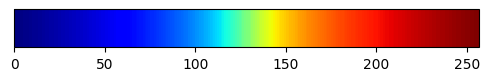

In [63]:
new_cmap = create_cmap()


def plot_Travel_Time_Diagram_32_24_C01(
    nc,
    df,
    focus_posi,
    occur_UT,
    BeiDou_posi,
    t_interval,
    winlong,
    winshort,
    sv='C01',
    to_save=False,
):
    # t_start = np.datetime64('2023-12-18T00:00:00')
    # t_end = np.datetime64('2023-12-19T00:00:00')
    # t_range = pd.date_range(t_start, t_end, freq=f'{t_interval}s')

    # obs_sites = ['WUHN']
    obs_sites = nc.observer.values

    t_start = np.datetime64('2023-12-18T00:00:00')
    t_end = np.datetime64('2023-12-18T16:00:00')
    x_start = np.datetime64('2023-12-18T00:00:00')
    x_end = np.datetime64('2023-12-18T10:00:00')
    # unit: minute

    p_units = 'min'
    v_units = 'km'
    label = f'DTEC'
    ylabel = 'Distance'
    title = f'{winlong}-{winshort}{p_units} Filtered {sv} {label}'
    f_path = f'/home/koi/pypoetry/GNSS_TEC/plots'
    f_save = f'{f_path}/traveltime_{sv}_{label}_{winlong}-{winshort}{p_units}.png'

    fig = plt.figure(figsize=(13, 13))
    fig.suptitle(title, x=0.5, y=0.915)
    ax = plt.axes([0.10, 0.73, 0.62, 0.15])
    cx = plt.axes([0.10, 0.52, 0.62, 0.15], sharex=ax, sharey=ax)
    ex = plt.axes([0.10, 0.31, 0.62, 0.15], sharex=ax, sharey=ax)
    gx = plt.axes([0.10, 0.1, 0.62, 0.15], sharex=ax, sharey=ax)

    proj = ccrs.PlateCarree()
    bx = plt.axes([0.77, 0.73, 0.15, 0.15], projection=proj)
    dx = plt.axes([0.77, 0.52, 0.15, 0.15], projection=proj)
    fx = plt.axes([0.77, 0.31, 0.15, 0.15], projection=proj)
    hx = plt.axes([0.77, 0.1, 0.15, 0.15], projection=proj)
    cbarx = fig.add_axes([0.25, 0.03, 0.32, 0.014])
    set_maps(bx, dx, fx, hx, focus_posi, proj)

    ax.set_title(f'a) N.E. {label}', loc='left'), bx.set_title(f'b) IPPs', loc='left')
    cx.set_title(f'c) S.E. {label}', loc='left'), dx.set_title(f'd) IPPs', loc='left')
    ex.set_title(f'e) S.W. {label}', loc='left'), fx.set_title(f'f) IPPs', loc='left')
    gx.set_title(f'g) N.W. {label}', loc='left'), hx.set_title(f'h) IPPs', loc='left')

    # site = 'WUHN'
    for site in obs_sites:
        svs = nc.sel(observer=site).sv.values
        if sv not in svs:
            continue
        else:
            pass

        # if Path(f_save).is_file():
        #     continue
        # else:
        #     pass

        site_posi = [
            df[df.OBSERVATION == site].LON.values,
            df[df.OBSERVATION == site].LAT.values,
        ]
        # pprint(site_posi)
        # continue
        # site_posi = [114.3573, 30.5317]
        stec = nc.sTEC_smth.sel(observer=site, sv=sv).dropna(dim='time')
        t_range = stec.time.loc[t_start:t_end]
        stec = stec.sel(time=t_range).values

        if stec.size < int(12 * 60 * 60 / t_interval):
            continue

        # stec = stec.interp(
        #     time=t_range, method='linear', kwargs={'fill_value': 'extrapolate'}
        # )
        # t_range = stec.time
        zenith = nc.zenith.sel(observer=site, sv=sv).values
        ipp_posi = [
            nc.lon.sel(observer=site, sv=sv).values,
            nc.lat.sel(observer=site, sv=sv).values,
        ]

        maxdist = 1200  ## unit: km
        dist, bear, _ = measure_dist_bear_orient(focus_posi, ipp_posi)
        if dist > maxdist:
            continue
        else:
            pass

        vtec = stec * np.cos(zenith)
        ### normalization
        data = Signal(vtec, t_interval)

        notrend = data.savgol_dtrend_filter(winlong * 60 + 1, winshort * 60 + 1)

        one_quarter = np.pi / 2
        if bear >= 0 and bear < one_quarter:
            leftx, rightx = ax, bx
        elif bear >= one_quarter and bear < 2 * one_quarter:
            leftx, rightx = cx, dx
        elif bear >= 2 * one_quarter and bear < 3 * one_quarter:
            leftx, rightx = ex, fx
        else:
            leftx, rightx = gx, hx

        try:
            im = plot_vars(
                leftx,
                rightx,
                t_range,
                dist,
                notrend,
                site_posi,
                ipp_posi,
                new_cmap,
                # vmax=0.15,
                vmax=6*notrend.std(),
                skip=1,
                s=5.5,
                marker='^',
                alpha=0.75,
            )
        except Exception as e:
            print(e)

    fig.colorbar(im, cax=cbarx, orientation='horizontal', extend='both', pad=0.02)

    arrival_t = (
        np.datetime64('2023-12-18T00:30:00'),
        np.datetime64('2023-12-18T02:40:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.01,
        xytext=[3, 1],
    )

    arrival_t = (
        np.datetime64('2023-12-18T02:54:00'),
        np.datetime64('2023-12-18T04:15:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=1,
        xytext=[-60, 1],
    )

    arrival_t = (
        np.datetime64('2023-12-18T03:22:00'),
        np.datetime64('2023-12-18T04:30:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.01,
        xytext=[3, 1],
    )

    arrival_t = (
        np.datetime64('2023-12-18T07:01:00'),
        np.datetime64('2023-12-18T08:35:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.01,
        xytext=[3, 1],
    )

    for the_ax in [ax, cx, ex, gx]:
        the_ax.axvline(occur_UT, color='#cccccc', alpha=0.9, ls='--', lw=2)
        the_ax.set_ylabel(f'{ylabel} ({v_units})')

    ax.set_xlim([x_start, x_end])
    ax.set_ylim([0, maxdist])
    ticks = np.arange(0, 26, 2)
    ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(format_func)

    gx.set_xlabel(f'Time (UT)')
    if to_save:
        fig.savefig(f_save, bbox_inches='tight')
    else:
        plt.show()
    plt.clf()
    plt.close('all')
    gc.collect()


# plot_Travel_Time_Diagram_32_24_C01(
#     nc,
#     df,
#     focus_posi,
#     occur_UT,
#     BeiDou_posi,
#     t_interval,
#     winlong,
#     winshort,
#     sv='C01',
#     to_save=True,
# )

#### Sv: C02

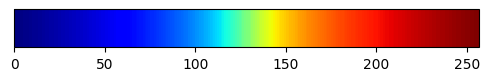

In [64]:
new_cmap = create_cmap()


def plot_Travel_Time_Diagram_32_24_C02(
    nc,
    df,
    focus_posi,
    occur_UT,
    BeiDou_posi,
    t_interval,
    winlong,
    winshort,
    sv='C02',
    to_save=False,
):
    # t_start = np.datetime64('2023-12-18T00:00:00')
    # t_end = np.datetime64('2023-12-19T00:00:00')
    # t_range = pd.date_range(t_start, t_end, freq=f'{t_interval}s')

    # obs_sites = ['WUHN']
    obs_sites = nc.observer.values

    t_start = np.datetime64('2023-12-18T00:00:00')
    t_end = np.datetime64('2023-12-18T16:00:00')
    x_start = np.datetime64('2023-12-18T00:00:00')
    x_end = np.datetime64('2023-12-18T10:00:00')
    # unit: minute

    p_units = 'min'
    v_units = 'km'
    label = f'DTEC'
    ylabel = 'Distance'
    title = f'{winlong}-{winshort}{p_units} Filtered {sv} {label}'
    f_path = f'/home/koi/pypoetry/GNSS_TEC/plots'
    f_save = f'{f_path}/traveltime_{sv}_{label}_{winlong}-{winshort}{p_units}.png'

    fig = plt.figure(figsize=(13, 13))
    fig.suptitle(title, x=0.5, y=0.915)
    ax = plt.axes([0.10, 0.73, 0.62, 0.15])
    cx = plt.axes([0.10, 0.52, 0.62, 0.15], sharex=ax, sharey=ax)
    ex = plt.axes([0.10, 0.31, 0.62, 0.15], sharex=ax, sharey=ax)
    gx = plt.axes([0.10, 0.1, 0.62, 0.15], sharex=ax, sharey=ax)

    proj = ccrs.PlateCarree()
    bx = plt.axes([0.77, 0.73, 0.15, 0.15], projection=proj)
    dx = plt.axes([0.77, 0.52, 0.15, 0.15], projection=proj)
    fx = plt.axes([0.77, 0.31, 0.15, 0.15], projection=proj)
    hx = plt.axes([0.77, 0.1, 0.15, 0.15], projection=proj)
    cbarx = fig.add_axes([0.25, 0.03, 0.32, 0.014])
    set_maps(bx, dx, fx, hx, focus_posi, proj)

    ax.set_title(f'a) N.E. {label}', loc='left'), bx.set_title(f'b) IPPs', loc='left')
    cx.set_title(f'c) S.E. {label}', loc='left'), dx.set_title(f'd) IPPs', loc='left')
    ex.set_title(f'e) S.W. {label}', loc='left'), fx.set_title(f'f) IPPs', loc='left')
    gx.set_title(f'g) N.W. {label}', loc='left'), hx.set_title(f'h) IPPs', loc='left')

    # site = 'WUHN'
    for site in obs_sites:
        svs = nc.sel(observer=site).sv.values
        if sv not in svs:
            continue
        else:
            pass

        # if Path(f_save).is_file():
        #     continue
        # else:
        #     pass

        site_posi = [
            df[df.OBSERVATION == site].LON.values,
            df[df.OBSERVATION == site].LAT.values,
        ]
        # pprint(site_posi)
        # continue
        # site_posi = [114.3573, 30.5317]
        stec = nc.sTEC_smth.sel(observer=site, sv=sv).dropna(dim='time')
        t_range = stec.time.loc[t_start:t_end]
        stec = stec.sel(time=t_range).values

        if stec.size < int(12 * 60 * 60 / t_interval):
            continue

        # stec = stec.interp(
        #     time=t_range, method='linear', kwargs={'fill_value': 'extrapolate'}
        # )
        # t_range = stec.time
        zenith = nc.zenith.sel(observer=site, sv=sv).values
        ipp_posi = [
            nc.lon.sel(observer=site, sv=sv).values,
            nc.lat.sel(observer=site, sv=sv).values,
        ]

        maxdist = 1200  ## unit: km
        dist, bear, _ = measure_dist_bear_orient(focus_posi, ipp_posi)
        if dist > maxdist:
            continue
        else:
            pass

        vtec = stec * np.cos(zenith)
        ### normalization
        data = Signal(vtec, t_interval)

        notrend = data.savgol_dtrend_filter(
            winlong * 60 + 1, winshort * 60 + 1, order=3
        )
        # notrend = notrend/max(notrend)

        one_quarter = np.pi / 2
        if bear >= 0 and bear < one_quarter:
            leftx, rightx = ax, bx
        elif bear >= one_quarter and bear < 2 * one_quarter:
            leftx, rightx = cx, dx
        elif bear >= 2 * one_quarter and bear < 3 * one_quarter:
            leftx, rightx = ex, fx
        else:
            leftx, rightx = gx, hx

        try:
            im = plot_vars(
                leftx,
                rightx,
                t_range,
                dist,
                notrend,
                site_posi,
                ipp_posi,
                new_cmap,
                vmax=8 * notrend.std(),
                skip=1,
                s=4.5,
                marker='^',
                alpha=0.75,
            )
        except Exception as e:
            print(e)

    fig.colorbar(im, cax=cbarx, orientation='horizontal', extend='both', pad=0.02)

    arrival_t = (
        np.datetime64('2023-12-18T03:45:00'),
        np.datetime64('2023-12-18T05:10:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        ex,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.01,
        xytext=[3, 1],
    )

    for the_ax in [ax, cx, ex, gx]:
        the_ax.axvline(occur_UT, color='#cccccc', alpha=0.9, ls='--', lw=2)
        the_ax.set_ylabel(f'{ylabel} ({v_units})')

    ax.set_xlim([x_start, x_end])
    ax.set_ylim([0, maxdist])
    ticks = np.arange(0, 26, 2)
    ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(format_func)

    gx.set_xlabel(f'Time (UT)')
    if to_save:
        fig.savefig(f_save, bbox_inches='tight')
    else:
        plt.show()
    plt.clf()
    plt.close('all')
    gc.collect()


plot_Travel_Time_Diagram_32_24_C02(
    nc,
    df,
    focus_posi,
    occur_UT,
    BeiDou_posi,
    t_interval,
    winlong,
    winshort,
    sv='C02',
    to_save=True,
)

#### Sv: C03

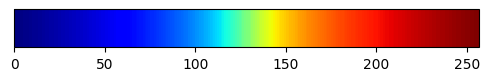

In [65]:
new_cmap = create_cmap()


def plot_Travel_Time_Diagram_32_24_C03(
    nc,
    df,
    focus_posi,
    occur_UT,
    BeiDou_posi,
    t_interval,
    winlong,
    winshort,
    sv='C03',
    to_save=False,
):
    # t_start = np.datetime64('2023-12-18T00:00:00')
    # t_end = np.datetime64('2023-12-19T00:00:00')
    # t_range = pd.date_range(t_start, t_end, freq=f'{t_interval}s')

    # obs_sites = ['WUHN']
    obs_sites = nc.observer.values

    t_start = np.datetime64('2023-12-18T00:00:00')
    t_end = np.datetime64('2023-12-18T16:00:00')
    x_start = np.datetime64('2023-12-18T00:00:00')
    x_end = np.datetime64('2023-12-18T10:00:00')
    # unit: minute

    p_units = 'min'
    v_units = 'km'
    label = f'DTEC'
    ylabel = 'Distance'
    title = f'{winlong}-{winshort}{p_units} Filtered {sv} {label}'
    f_path = f'/home/koi/pypoetry/GNSS_TEC/plots'
    f_save = f'{f_path}/traveltime_{sv}_{label}_{winlong}-{winshort}{p_units}.png'

    fig = plt.figure(figsize=(13, 13))
    fig.suptitle(title, x=0.5, y=0.915)
    ax = plt.axes([0.10, 0.73, 0.62, 0.15])
    cx = plt.axes([0.10, 0.52, 0.62, 0.15], sharex=ax, sharey=ax)
    ex = plt.axes([0.10, 0.31, 0.62, 0.15], sharex=ax, sharey=ax)
    gx = plt.axes([0.10, 0.1, 0.62, 0.15], sharex=ax, sharey=ax)

    proj = ccrs.PlateCarree()
    bx = plt.axes([0.77, 0.73, 0.15, 0.15], projection=proj)
    dx = plt.axes([0.77, 0.52, 0.15, 0.15], projection=proj)
    fx = plt.axes([0.77, 0.31, 0.15, 0.15], projection=proj)
    hx = plt.axes([0.77, 0.1, 0.15, 0.15], projection=proj)
    cbarx = fig.add_axes([0.25, 0.03, 0.32, 0.014])
    set_maps(bx, dx, fx, hx, focus_posi, proj)

    ax.set_title(f'a) N.E. {label}', loc='left'), bx.set_title(f'b) IPPs', loc='left')
    cx.set_title(f'c) S.E. {label}', loc='left'), dx.set_title(f'd) IPPs', loc='left')
    ex.set_title(f'e) S.W. {label}', loc='left'), fx.set_title(f'f) IPPs', loc='left')
    gx.set_title(f'g) N.W. {label}', loc='left'), hx.set_title(f'h) IPPs', loc='left')

    # site = 'WUHN'
    for site in obs_sites:
        svs = nc.sel(observer=site).sv.values
        if sv not in svs:
            continue
        else:
            pass

        # if Path(f_save).is_file():
        #     continue
        # else:
        #     pass

        site_posi = [
            df[df.OBSERVATION == site].LON.values,
            df[df.OBSERVATION == site].LAT.values,
        ]
        # pprint(site_posi)
        # continue
        # site_posi = [114.3573, 30.5317]
        stec = nc.sTEC_smth.sel(observer=site, sv=sv).dropna(dim='time')
        t_range = stec.time.loc[t_start:t_end]
        stec = stec.sel(time=t_range).values

        if stec.size < int(12 * 60 * 60 / t_interval):
            continue

        # stec = stec.interp(
        #     time=t_range, method='linear', kwargs={'fill_value': 'extrapolate'}
        # )
        # t_range = stec.time
        zenith = nc.zenith.sel(observer=site, sv=sv).values
        ipp_posi = [
            nc.lon.sel(observer=site, sv=sv).values,
            nc.lat.sel(observer=site, sv=sv).values,
        ]

        maxdist = 1200  ## unit: km
        dist, bear, _ = measure_dist_bear_orient(focus_posi, ipp_posi)
        if dist > maxdist:
            continue
        else:
            pass

        vtec = stec * np.cos(zenith)
        ### normalization
        data = Signal(vtec, t_interval)

        notrend = data.savgol_dtrend_filter(
            winlong * 60 + 1, winshort * 60 + 1, order=3
        )
        # notrend = notrend/max(notrend)

        one_quarter = np.pi / 2
        if bear >= 0 and bear < one_quarter:
            leftx, rightx = ax, bx
        elif bear >= one_quarter and bear < 2 * one_quarter:
            leftx, rightx = cx, dx
        elif bear >= 2 * one_quarter and bear < 3 * one_quarter:
            leftx, rightx = ex, fx
        else:
            leftx, rightx = gx, hx

        try:
            im = plot_vars(
                leftx,
                rightx,
                t_range,
                dist,
                notrend,
                site_posi,
                ipp_posi,
                new_cmap,
                vmax=7 * notrend.std(),
                skip=1,
                s=4.5,
                marker='^',
                alpha=0.75,
            )
        except Exception as e:
            print(e)

    fig.colorbar(im, cax=cbarx, orientation='horizontal', extend='both', pad=0.02)

    arrival_t = (
        np.datetime64('2023-12-18T00:36:00'),
        np.datetime64('2023-12-18T02:40:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.01,
        xytext=[3, 1],
    )

    arrival_t = (
        np.datetime64('2023-12-18T02:54:00'),
        np.datetime64('2023-12-18T04:15:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=1,
        xytext=[-60, 1],
    )


    for the_ax in [ax, cx, ex, gx]:
        the_ax.axvline(occur_UT, color='#cccccc', alpha=0.9, ls='--', lw=2)
        the_ax.set_ylabel(f'{ylabel} ({v_units})')

    ax.set_xlim([x_start, x_end])
    ax.set_ylim([0, maxdist])
    ticks = np.arange(0, 26, 2)
    ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(format_func)

    gx.set_xlabel(f'Time (UT)')
    if to_save:
        fig.savefig(f_save, bbox_inches='tight')
    else:
        plt.show()
    plt.clf()
    plt.close('all')
    gc.collect()


plot_Travel_Time_Diagram_32_24_C03(
    nc,
    df,
    focus_posi,
    occur_UT,
    BeiDou_posi,
    t_interval,
    winlong,
    winshort,
    sv='C03',
    to_save=True,
)

### Periods: 24min-16min

In [66]:
winlong, winshort = 24, 16

#### Sv: C01

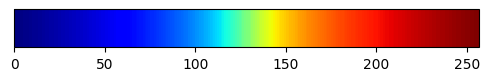

In [57]:
new_cmap = create_cmap()


def plot_Travel_Time_Diagram_24_16_C01(
    nc,
    df,
    focus_posi,
    occur_UT,
    BeiDou_posi,
    t_interval,
    winlong,
    winshort,
    sv='C01',
    to_save=False,
):
    # t_start = np.datetime64('2023-12-18T00:00:00')
    # t_end = np.datetime64('2023-12-19T00:00:00')
    # t_range = pd.date_range(t_start, t_end, freq=f'{t_interval}s')

    # obs_sites = ['WUHN']
    obs_sites = nc.observer.values

    t_start = np.datetime64('2023-12-18T00:00:00')
    t_end = np.datetime64('2023-12-18T16:00:00')
    x_start = np.datetime64('2023-12-18T00:00:00')
    x_end = np.datetime64('2023-12-18T10:00:00')
    # unit: minute

    p_units = 'min'
    v_units = 'km'
    label = f'DTEC'
    ylabel = 'Distance'
    title = f'{winlong}-{winshort}{p_units} Filtered {sv} {label}'
    f_path = f'/home/koi/pypoetry/GNSS_TEC/plots'
    f_save = f'{f_path}/traveltime_{sv}_{label}_{winlong}-{winshort}{p_units}.png'

    fig = plt.figure(figsize=(13, 13))
    fig.suptitle(title, x=0.5, y=0.915)
    ax = plt.axes([0.10, 0.73, 0.62, 0.15])
    cx = plt.axes([0.10, 0.52, 0.62, 0.15], sharex=ax, sharey=ax)
    ex = plt.axes([0.10, 0.31, 0.62, 0.15], sharex=ax, sharey=ax)
    gx = plt.axes([0.10, 0.1, 0.62, 0.15], sharex=ax, sharey=ax)

    proj = ccrs.PlateCarree()
    bx = plt.axes([0.77, 0.73, 0.15, 0.15], projection=proj)
    dx = plt.axes([0.77, 0.52, 0.15, 0.15], projection=proj)
    fx = plt.axes([0.77, 0.31, 0.15, 0.15], projection=proj)
    hx = plt.axes([0.77, 0.1, 0.15, 0.15], projection=proj)
    cbarx = fig.add_axes([0.25, 0.03, 0.32, 0.014])
    set_maps(bx, dx, fx, hx, focus_posi, proj)

    ax.set_title(f'a) N.E. {label}', loc='left'), bx.set_title(f'b) IPPs', loc='left')
    cx.set_title(f'c) S.E. {label}', loc='left'), dx.set_title(f'd) IPPs', loc='left')
    ex.set_title(f'e) S.W. {label}', loc='left'), fx.set_title(f'f) IPPs', loc='left')
    gx.set_title(f'g) N.W. {label}', loc='left'), hx.set_title(f'h) IPPs', loc='left')

    # site = 'WUHN'
    for site in obs_sites:
        svs = nc.sel(observer=site).sv.values
        if sv not in svs:
            continue
        else:
            pass

        # if Path(f_save).is_file():
        #     continue
        # else:
        #     pass

        site_posi = [
            df[df.OBSERVATION == site].LON.values,
            df[df.OBSERVATION == site].LAT.values,
        ]
        # pprint(site_posi)
        # continue
        # site_posi = [114.3573, 30.5317]
        stec = nc.sTEC_smth.sel(observer=site, sv=sv).dropna(dim='time')
        t_range = stec.time.loc[t_start:t_end]
        stec = stec.sel(time=t_range).values

        if stec.size < int(12 * 60 * 60 / t_interval):
            continue

        # stec = stec.interp(
        #     time=t_range, method='linear', kwargs={'fill_value': 'extrapolate'}
        # )
        # t_range = stec.time
        zenith = nc.zenith.sel(observer=site, sv=sv).values
        ipp_posi = [
            nc.lon.sel(observer=site, sv=sv).values,
            nc.lat.sel(observer=site, sv=sv).values,
        ]

        maxdist = 1200  ## unit: km
        dist, bear, _ = measure_dist_bear_orient(focus_posi, ipp_posi)
        if dist > maxdist:
            continue
        else:
            pass

        vtec = stec * np.cos(zenith)
        ### normalization
        data = Signal(vtec, t_interval)

        notrend = data.savgol_dtrend_filter(winlong * 60 + 1, winshort * 60 + 1)

        one_quarter = np.pi / 2
        if bear >= 0 and bear < one_quarter:
            leftx, rightx = ax, bx
        elif bear >= one_quarter and bear < 2 * one_quarter:
            leftx, rightx = cx, dx
        elif bear >= 2 * one_quarter and bear < 3 * one_quarter:
            leftx, rightx = ex, fx
        else:
            leftx, rightx = gx, hx

        try:
            im = plot_vars(
                leftx,
                rightx,
                t_range,
                dist,
                notrend,
                site_posi,
                ipp_posi,
                new_cmap,
                # vmax=0.15,
                vmax=6*notrend.std(),
                skip=1,
                s=5.5,
                marker='^',
                alpha=0.75,
            )
        except Exception as e:
            print(e)

    fig.colorbar(im, cax=cbarx, orientation='horizontal', extend='both', pad=0.02)

    arrival_t = (
        np.datetime64('2023-12-18T00:30:00'),
        np.datetime64('2023-12-18T02:40:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.01,
        xytext=[3, 1],
    )

    arrival_t = (
        np.datetime64('2023-12-18T02:54:00'),
        np.datetime64('2023-12-18T04:15:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=1,
        xytext=[-60, 1],
    )

    arrival_t = (
        np.datetime64('2023-12-18T03:22:00'),
        np.datetime64('2023-12-18T04:30:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.01,
        xytext=[3, 1],
    )

    arrival_t = (
        np.datetime64('2023-12-18T07:01:00'),
        np.datetime64('2023-12-18T08:35:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.01,
        xytext=[3, 1],
    )

    for the_ax in [ax, cx, ex, gx]:
        the_ax.axvline(occur_UT, color='#cccccc', alpha=0.9, ls='--', lw=2)
        the_ax.set_ylabel(f'{ylabel} ({v_units})')

    ax.set_xlim([x_start, x_end])
    ax.set_ylim([0, maxdist])
    ticks = np.arange(0, 26, 2)
    ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(format_func)

    gx.set_xlabel(f'Time (UT)')
    if to_save:
        fig.savefig(f_save, bbox_inches='tight')
    else:
        plt.show()
    plt.clf()
    plt.close('all')
    gc.collect()


# plot_Travel_Time_Diagram_24_16_C01(
#     nc,
#     df,
#     focus_posi,
#     occur_UT,
#     BeiDou_posi,
#     t_interval,
#     winlong,
#     winshort,
#     sv='C01',
#     to_save=True,
# )

#### Sv: C02

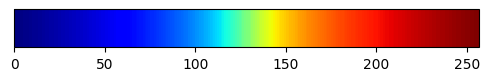

In [53]:
new_cmap = create_cmap()


def plot_Travel_Time_Diagram_24_16_C02(
    nc,
    df,
    focus_posi,
    occur_UT,
    BeiDou_posi,
    t_interval,
    winlong,
    winshort,
    sv='C02',
    to_save=False,
):
    # t_start = np.datetime64('2023-12-18T00:00:00')
    # t_end = np.datetime64('2023-12-19T00:00:00')
    # t_range = pd.date_range(t_start, t_end, freq=f'{t_interval}s')

    # obs_sites = ['WUHN']
    obs_sites = nc.observer.values

    t_start = np.datetime64('2023-12-18T00:00:00')
    t_end = np.datetime64('2023-12-18T16:00:00')
    x_start = np.datetime64('2023-12-18T00:00:00')
    x_end = np.datetime64('2023-12-18T10:00:00')
    # unit: minute

    p_units = 'min'
    v_units = 'km'
    label = f'DTEC'
    ylabel = 'Distance'
    title = f'{winlong}-{winshort}{p_units} Filtered {sv} {label}'
    f_path = f'/home/koi/pypoetry/GNSS_TEC/plots'
    f_save = f'{f_path}/traveltime_{sv}_{label}_{winlong}-{winshort}{p_units}.png'

    fig = plt.figure(figsize=(13, 13))
    fig.suptitle(title, x=0.5, y=0.915)
    ax = plt.axes([0.10, 0.73, 0.62, 0.15])
    cx = plt.axes([0.10, 0.52, 0.62, 0.15], sharex=ax, sharey=ax)
    ex = plt.axes([0.10, 0.31, 0.62, 0.15], sharex=ax, sharey=ax)
    gx = plt.axes([0.10, 0.1, 0.62, 0.15], sharex=ax, sharey=ax)

    proj = ccrs.PlateCarree()
    bx = plt.axes([0.77, 0.73, 0.15, 0.15], projection=proj)
    dx = plt.axes([0.77, 0.52, 0.15, 0.15], projection=proj)
    fx = plt.axes([0.77, 0.31, 0.15, 0.15], projection=proj)
    hx = plt.axes([0.77, 0.1, 0.15, 0.15], projection=proj)
    cbarx = fig.add_axes([0.25, 0.03, 0.32, 0.014])
    set_maps(bx, dx, fx, hx, focus_posi, proj)

    ax.set_title(f'a) N.E. {label}', loc='left'), bx.set_title(f'b) IPPs', loc='left')
    cx.set_title(f'c) S.E. {label}', loc='left'), dx.set_title(f'd) IPPs', loc='left')
    ex.set_title(f'e) S.W. {label}', loc='left'), fx.set_title(f'f) IPPs', loc='left')
    gx.set_title(f'g) N.W. {label}', loc='left'), hx.set_title(f'h) IPPs', loc='left')

    # site = 'WUHN'
    for site in obs_sites:
        svs = nc.sel(observer=site).sv.values
        if sv not in svs:
            continue
        else:
            pass

        # if Path(f_save).is_file():
        #     continue
        # else:
        #     pass

        site_posi = [
            df[df.OBSERVATION == site].LON.values,
            df[df.OBSERVATION == site].LAT.values,
        ]
        # pprint(site_posi)
        # continue
        # site_posi = [114.3573, 30.5317]
        stec = nc.sTEC_smth.sel(observer=site, sv=sv).dropna(dim='time')
        t_range = stec.time.loc[t_start:t_end]
        stec = stec.sel(time=t_range).values

        if stec.size < int(12 * 60 * 60 / t_interval):
            continue

        # stec = stec.interp(
        #     time=t_range, method='linear', kwargs={'fill_value': 'extrapolate'}
        # )
        # t_range = stec.time
        zenith = nc.zenith.sel(observer=site, sv=sv).values
        ipp_posi = [
            nc.lon.sel(observer=site, sv=sv).values,
            nc.lat.sel(observer=site, sv=sv).values,
        ]

        maxdist = 1200  ## unit: km
        dist, bear, _ = measure_dist_bear_orient(focus_posi, ipp_posi)
        if dist > maxdist:
            continue
        else:
            pass

        vtec = stec * np.cos(zenith)
        ### normalization
        data = Signal(vtec, t_interval)

        notrend = data.savgol_dtrend_filter(
            winlong * 60 + 1, winshort * 60 + 1, order=3
        )
        # notrend = notrend/max(notrend)

        one_quarter = np.pi / 2
        if bear >= 0 and bear < one_quarter:
            leftx, rightx = ax, bx
        elif bear >= one_quarter and bear < 2 * one_quarter:
            leftx, rightx = cx, dx
        elif bear >= 2 * one_quarter and bear < 3 * one_quarter:
            leftx, rightx = ex, fx
        else:
            leftx, rightx = gx, hx

        try:
            im = plot_vars(
                leftx,
                rightx,
                t_range,
                dist,
                notrend,
                site_posi,
                ipp_posi,
                new_cmap,
                vmax=8 * notrend.std(),
                skip=1,
                s=4.5,
                marker='^',
                alpha=0.75,
            )
        except Exception as e:
            print(e)

    fig.colorbar(im, cax=cbarx, orientation='horizontal', extend='both', pad=0.02)

    arrival_t = (
        np.datetime64('2023-12-18T03:45:00'),
        np.datetime64('2023-12-18T05:10:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        ex,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.01,
        xytext=[3, 1],
    )

    for the_ax in [ax, cx, ex, gx]:
        the_ax.axvline(occur_UT, color='#cccccc', alpha=0.9, ls='--', lw=2)
        the_ax.set_ylabel(f'{ylabel} ({v_units})')

    ax.set_xlim([x_start, x_end])
    ax.set_ylim([0, maxdist])
    ticks = np.arange(0, 26, 2)
    ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(format_func)

    gx.set_xlabel(f'Time (UT)')
    if to_save:
        fig.savefig(f_save, bbox_inches='tight')
    else:
        plt.show()
    plt.clf()
    plt.close('all')
    gc.collect()


# plot_Travel_Time_Diagram_24_16_C02(
#     nc,
#     df,
#     focus_posi,
#     occur_UT,
#     BeiDou_posi,
#     t_interval,
#     winlong,
#     winshort,
#     sv='C02',
#     to_save=True,
# )

In [ ]:
#### Sv: C03

#### Sv: C03

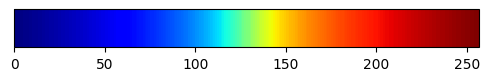

In [61]:
new_cmap = create_cmap()


def plot_Travel_Time_Diagram_24_16_C03(
    nc,
    df,
    focus_posi,
    occur_UT,
    BeiDou_posi,
    t_interval,
    winlong,
    winshort,
    sv='C03',
    to_save=False,
):
    # t_start = np.datetime64('2023-12-18T00:00:00')
    # t_end = np.datetime64('2023-12-19T00:00:00')
    # t_range = pd.date_range(t_start, t_end, freq=f'{t_interval}s')

    # obs_sites = ['WUHN']
    obs_sites = nc.observer.values

    t_start = np.datetime64('2023-12-18T00:00:00')
    t_end = np.datetime64('2023-12-18T16:00:00')
    x_start = np.datetime64('2023-12-18T00:00:00')
    x_end = np.datetime64('2023-12-18T10:00:00')
    # unit: minute

    p_units = 'min'
    v_units = 'km'
    label = f'DTEC'
    ylabel = 'Distance'
    title = f'{winlong}-{winshort}{p_units} Filtered {sv} {label}'
    f_path = f'/home/koi/pypoetry/GNSS_TEC/plots'
    f_save = f'{f_path}/traveltime_{sv}_{label}_{winlong}-{winshort}{p_units}.png'

    fig = plt.figure(figsize=(13, 13))
    fig.suptitle(title, x=0.5, y=0.915)
    ax = plt.axes([0.10, 0.73, 0.62, 0.15])
    cx = plt.axes([0.10, 0.52, 0.62, 0.15], sharex=ax, sharey=ax)
    ex = plt.axes([0.10, 0.31, 0.62, 0.15], sharex=ax, sharey=ax)
    gx = plt.axes([0.10, 0.1, 0.62, 0.15], sharex=ax, sharey=ax)

    proj = ccrs.PlateCarree()
    bx = plt.axes([0.77, 0.73, 0.15, 0.15], projection=proj)
    dx = plt.axes([0.77, 0.52, 0.15, 0.15], projection=proj)
    fx = plt.axes([0.77, 0.31, 0.15, 0.15], projection=proj)
    hx = plt.axes([0.77, 0.1, 0.15, 0.15], projection=proj)
    cbarx = fig.add_axes([0.25, 0.03, 0.32, 0.014])
    set_maps(bx, dx, fx, hx, focus_posi, proj)

    ax.set_title(f'a) N.E. {label}', loc='left'), bx.set_title(f'b) IPPs', loc='left')
    cx.set_title(f'c) S.E. {label}', loc='left'), dx.set_title(f'd) IPPs', loc='left')
    ex.set_title(f'e) S.W. {label}', loc='left'), fx.set_title(f'f) IPPs', loc='left')
    gx.set_title(f'g) N.W. {label}', loc='left'), hx.set_title(f'h) IPPs', loc='left')

    # site = 'WUHN'
    for site in obs_sites:
        svs = nc.sel(observer=site).sv.values
        if sv not in svs:
            continue
        else:
            pass

        # if Path(f_save).is_file():
        #     continue
        # else:
        #     pass

        site_posi = [
            df[df.OBSERVATION == site].LON.values,
            df[df.OBSERVATION == site].LAT.values,
        ]
        # pprint(site_posi)
        # continue
        # site_posi = [114.3573, 30.5317]
        stec = nc.sTEC_smth.sel(observer=site, sv=sv).dropna(dim='time')
        t_range = stec.time.loc[t_start:t_end]
        stec = stec.sel(time=t_range).values

        if stec.size < int(12 * 60 * 60 / t_interval):
            continue

        # stec = stec.interp(
        #     time=t_range, method='linear', kwargs={'fill_value': 'extrapolate'}
        # )
        # t_range = stec.time
        zenith = nc.zenith.sel(observer=site, sv=sv).values
        ipp_posi = [
            nc.lon.sel(observer=site, sv=sv).values,
            nc.lat.sel(observer=site, sv=sv).values,
        ]

        maxdist = 1200  ## unit: km
        dist, bear, _ = measure_dist_bear_orient(focus_posi, ipp_posi)
        if dist > maxdist:
            continue
        else:
            pass

        vtec = stec * np.cos(zenith)
        ### normalization
        data = Signal(vtec, t_interval)

        notrend = data.savgol_dtrend_filter(
            winlong * 60 + 1, winshort * 60 + 1, order=3
        )
        # notrend = notrend/max(notrend)

        one_quarter = np.pi / 2
        if bear >= 0 and bear < one_quarter:
            leftx, rightx = ax, bx
        elif bear >= one_quarter and bear < 2 * one_quarter:
            leftx, rightx = cx, dx
        elif bear >= 2 * one_quarter and bear < 3 * one_quarter:
            leftx, rightx = ex, fx
        else:
            leftx, rightx = gx, hx

        try:
            im = plot_vars(
                leftx,
                rightx,
                t_range,
                dist,
                notrend,
                site_posi,
                ipp_posi,
                new_cmap,
                vmax=7 * notrend.std(),
                skip=1,
                s=4.5,
                marker='^',
                alpha=0.75,
            )
        except Exception as e:
            print(e)

    fig.colorbar(im, cax=cbarx, orientation='horizontal', extend='both', pad=0.02)

    arrival_t = (
        np.datetime64('2023-12-18T00:36:00'),
        np.datetime64('2023-12-18T02:40:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=0.01,
        xytext=[3, 1],
    )

    arrival_t = (
        np.datetime64('2023-12-18T02:54:00'),
        np.datetime64('2023-12-18T04:15:00'),
    )
    arrival_d = 0, 1200
    add_speed_line(
        cx,
        arrival_t,
        arrival_d,
        dinterval=1 * const.kilo,
        sunit='m/s',
        scalar=1,
        xytext=[-60, 1],
    )


    for the_ax in [ax, cx, ex, gx]:
        the_ax.axvline(occur_UT, color='#cccccc', alpha=0.9, ls='--', lw=2)
        the_ax.set_ylabel(f'{ylabel} ({v_units})')

    ax.set_xlim([x_start, x_end])
    ax.set_ylim([0, maxdist])
    ticks = np.arange(0, 26, 2)
    ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(format_func)

    gx.set_xlabel(f'Time (UT)')
    if to_save:
        fig.savefig(f_save, bbox_inches='tight')
    else:
        plt.show()
    plt.clf()
    plt.close('all')
    gc.collect()


# plot_Travel_Time_Diagram_24_16_C03(
#     nc,
#     df,
#     focus_posi,
#     occur_UT,
#     BeiDou_posi,
#     t_interval,
#     winlong,
#     winshort,
#     sv='C03',
#     to_save=True,
# )